In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quality-prediction-in-a-mining-process/MiningProcess_Flotation_Plant_Database.csv


In [2]:
# Create New Conda Environment and Use Conda Channel 
#!conda create -n newCondaEnvironment python=3.8 pandas=1.5 -y
#!source /opt/conda/bin/activate newCondaEnvironment

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor
import lightgbm
from lightgbm import plot_importance

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import warnings

pd.options.display.max_columns = None

%matplotlib inline

## Dataset Loadin

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df = pd.read_csv('/kaggle/input/quality-prediction-in-a-mining-process/MiningProcess_Flotation_Plant_Database.csv',decimal=",",parse_dates=["date"],infer_datetime_format=True)

In [6]:
df = reduce_mem_usage(df)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df = df.rename(columns=lambda x: '_'.join(x.split()))

In [9]:
df.duplicated().sum()

1171

**Notice, we don't drop these seemly duplicated data points. Since there might be essential in the follow up continuity check.**

In [10]:
df.head()

,date,%_Iron_Feed,%_Silica_Feed,Starch_Flow,Amina_Flow,Ore_Pulp_Flow,Ore_Pulp_pH,Ore_Pulp_Density,Flotation_Column_01_Air_Flow,Flotation_Column_02_Air_Flow,Flotation_Column_03_Air_Flow,Flotation_Column_04_Air_Flow,Flotation_Column_05_Air_Flow,Flotation_Column_06_Air_Flow,Flotation_Column_07_Air_Flow,Flotation_Column_01_Level,Flotation_Column_02_Level,Flotation_Column_03_Level,Flotation_Column_04_Level,Flotation_Column_05_Level,Flotation_Column_06_Level,Flotation_Column_07_Level,%_Iron_Concentrate,%_Silica_Concentrate
0,2017-03-10 01:00:00,55.200001,16.98,3019.530029,557.434021,395.713013,10.0664,1.74,249.214005,253.235001,250.576004,295.096008,306.399994,250.225006,250.884003,457.395996,432.962006,424.954010,443.558014,502.255005,446.369995,523.343994,66.910004,1.31
1,2017-03-10 01:00:00,55.200001,16.98,3024.409912,563.965027,397.382996,10.0672,1.74,249.718994,250.531998,250.862000,295.096008,306.399994,250.136993,248.994003,451.890991,429.559998,432.938995,448.085999,496.363007,445.921997,498.075012,66.910004,1.31
2,2017-03-10 01:00:00,55.200001,16.98,3043.459961,568.054016,399.667999,10.0680,1.74,249.740997,247.873993,250.313004,295.096008,306.399994,251.345001,248.070999,451.239990,468.927002,434.609985,449.687988,484.411011,447.825989,458.566986,66.910004,1.31
3,2017-03-10 01:00:00,55.200001,16.98,3047.360107,568.664978,397.938995,10.0689,1.74,249.917007,254.487000,250.048996,295.096008,306.399994,250.421997,251.147003,452.441010,458.165009,442.864990,446.209991,471.411011,437.690002,427.669006,66.910004,1.31
4,2017-03-10 01:00:00,55.200001,16.98,3033.689941,558.166992,400.253998,10.0697,1.74,250.203003,252.136002,249.895004,295.096008,306.399994,249.983002,248.927994,452.441010,452.899994,450.523010,453.670013,462.597992,443.682007,425.678986,66.910004,1.31


* Goal is to predict **% Silica Concentrate**
* Silica Concentrate is the impurity in the iron ore which needs to be removed
* The value of modeling on this target value is that it takes at least an hour to measure the impurity

In [12]:
total = df.isnull().sum()
percent = (df.isnull().sum()/df.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
date,0,0.0
%_Iron_Feed,0,0.0
%_Silica_Feed,0,0.0
Starch_Flow,0,0.0
Amina_Flow,0,0.0
Ore_Pulp_Flow,0,0.0
Ore_Pulp_pH,0,0.0
Ore_Pulp_Density,0,0.0
Flotation_Column_01_Air_Flow,0,0.0
Flotation_Column_02_Air_Flow,0,0.0


In [13]:
df.describe()

,%_Iron_Feed,%_Silica_Feed,Starch_Flow,Amina_Flow,Ore_Pulp_Flow,Ore_Pulp_pH,Ore_Pulp_Density,Flotation_Column_01_Air_Flow,Flotation_Column_02_Air_Flow,Flotation_Column_03_Air_Flow,Flotation_Column_04_Air_Flow,Flotation_Column_05_Air_Flow,Flotation_Column_06_Air_Flow,Flotation_Column_07_Air_Flow,Flotation_Column_01_Level,Flotation_Column_02_Level,Flotation_Column_03_Level,Flotation_Column_04_Level,Flotation_Column_05_Level,Flotation_Column_06_Level,Flotation_Column_07_Level,%_Iron_Concentrate,%_Silica_Concentrate
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,56.294743,14.651719,2869.140381,488.144653,397.578400,9.767639,1.680380,280.151886,277.159973,281.082489,299.447845,299.917816,292.071503,290.754883,520.244812,522.649597,531.352661,420.320984,425.251648,429.941040,421.021271,65.050049,2.326763
std,5.157743,6.807439,1215.203735,91.230537,9.699785,0.387007,0.069249,29.621286,30.149357,28.558270,2.572536,3.636578,30.217804,28.670105,131.014923,128.165054,150.842163,91.794434,84.535820,89.862228,84.891495,1.118645,1.125554
min,42.740002,1.310000,0.002026,241.669006,376.248993,8.753340,1.519820,175.509995,175.156006,176.468994,292.195007,286.295013,189.927994,185.962006,149.218002,210.751999,126.254997,162.201004,166.990997,155.841003,175.348999,62.049999,0.600000
25%,52.669998,8.940000,2076.320068,431.795990,394.264008,9.527360,1.647310,250.281006,250.457001,250.854996,298.262573,298.067993,262.540985,256.302002,416.977997,441.882996,411.325012,356.678986,357.653015,358.497009,356.772003,64.370003,1.440000
50%,56.080002,13.850000,3018.429932,504.393005,399.248993,9.798100,1.697600,299.343994,296.222992,298.696014,299.804993,299.887115,299.476990,299.010986,491.877991,495.955994,494.317993,411.973999,408.773010,424.664581,411.065002,65.209999,2.000000
75%,59.720001,19.600000,3727.729980,553.257019,402.967987,10.038000,1.728330,300.148987,300.690002,300.381989,300.638000,301.791138,303.061005,301.903992,594.114014,595.463989,601.249023,485.549011,484.329010,492.683990,476.464996,65.860001,3.010000
max,65.779999,33.400002,6300.229980,739.538025,418.640991,10.808100,1.853250,373.871002,375.992004,364.346008,305.871002,310.269989,370.910004,371.592987,862.273987,828.919006,886.822021,680.359009,675.643982,698.861023,659.901978,68.010002,5.530000


In [14]:
dt_df = df.set_index('date')

In [15]:
all_hours = pd.Series(data=pd.date_range(start=dt_df.index.min(), end=dt_df.index.max(), freq='H'))
mask = all_hours.isin(dt_df.index.values)
all_hours[~mask]

149   2017-03-16 06:00:00
150   2017-03-16 07:00:00
151   2017-03-16 08:00:00
152   2017-03-16 09:00:00
153   2017-03-16 10:00:00
              ...        
462   2017-03-29 07:00:00
463   2017-03-29 08:00:00
464   2017-03-29 09:00:00
465   2017-03-29 10:00:00
466   2017-03-29 11:00:00
Length: 318, dtype: datetime64[ns]

**Therefore, we choose only to reserve the data after 2017-03-29 12\:00\:00**

In [16]:
dt_df = dt_df.loc["2017-03-29 12:00:00":]

**The measurement frequency of most rows in the dataset is every 20 seconds according to what the publisher/author of the dataset mentions. This would imply that there should be 180 measurements in each hour if this information is correct.**

In [18]:
dt_df.groupby(dt_df.index).count()["%_Silica_Concentrate"].value_counts()

180    3947
179       1
Name: %_Silica_Concentrate, dtype: int64

In [19]:
dt_df.groupby(dt_df.index).count()["%_Silica_Concentrate"][dt_df.groupby(dt_df.index).count()["%_Silica_Concentrate"] < 180]

date
2017-04-10    179
Name: %_Silica_Concentrate, dtype: int64

In [20]:
dt_df.loc['2017-04-10'].groupby(dt_df.loc['2017-04-10'].index).count()['%_Silica_Concentrate']

date
2017-04-10 00:00:00    179
2017-04-10 01:00:00    180
2017-04-10 02:00:00    180
2017-04-10 03:00:00    180
2017-04-10 04:00:00    180
2017-04-10 05:00:00    180
2017-04-10 06:00:00    180
2017-04-10 07:00:00    180
2017-04-10 08:00:00    180
2017-04-10 09:00:00    180
2017-04-10 10:00:00    180
2017-04-10 11:00:00    180
2017-04-10 12:00:00    180
2017-04-10 13:00:00    180
2017-04-10 14:00:00    180
2017-04-10 15:00:00    180
2017-04-10 16:00:00    180
2017-04-10 17:00:00    180
2017-04-10 18:00:00    180
2017-04-10 19:00:00    180
2017-04-10 20:00:00    180
2017-04-10 21:00:00    180
2017-04-10 22:00:00    180
2017-04-10 23:00:00    180
Name: %_Silica_Concentrate, dtype: int64

Inspired by https://www.kaggle.com/code/matiasob/dataset-is-corrupt-and-should-not-be-used, it says it's an option to replace that missing timestamp with the latest datapoint behind it, which is **2017-04-09 23\:00\:00**

In [21]:
df_before = dt_df.copy().loc[:'2017-04-10 00:00:00']
df_after = dt_df.copy().loc['2017-04-10 01:00:00':]
new_date = pd.to_datetime('2017-04-10 00:00:00')
new_data = pd.DataFrame(df_before[-1:].values, index=[new_date], columns=df_before.columns)
df_before = pd.concat([df_before,new_data],axis=0)

dt_df = pd.concat([df_before, df_after])
dt_df.reset_index(drop=True)

dt_df["duration"] = 20
dt_df.loc[0,"duration"] = 0
dt_df.duration = dt_df.duration.cumsum()

dt_df['Date_with_seconds'] = pd.Timestamp("2017-03-29 12:00:00") + pd.to_timedelta(dt_df['duration'], unit='s')

dt_df = dt_df.set_index("Date_with_seconds")

<AxesSubplot:>

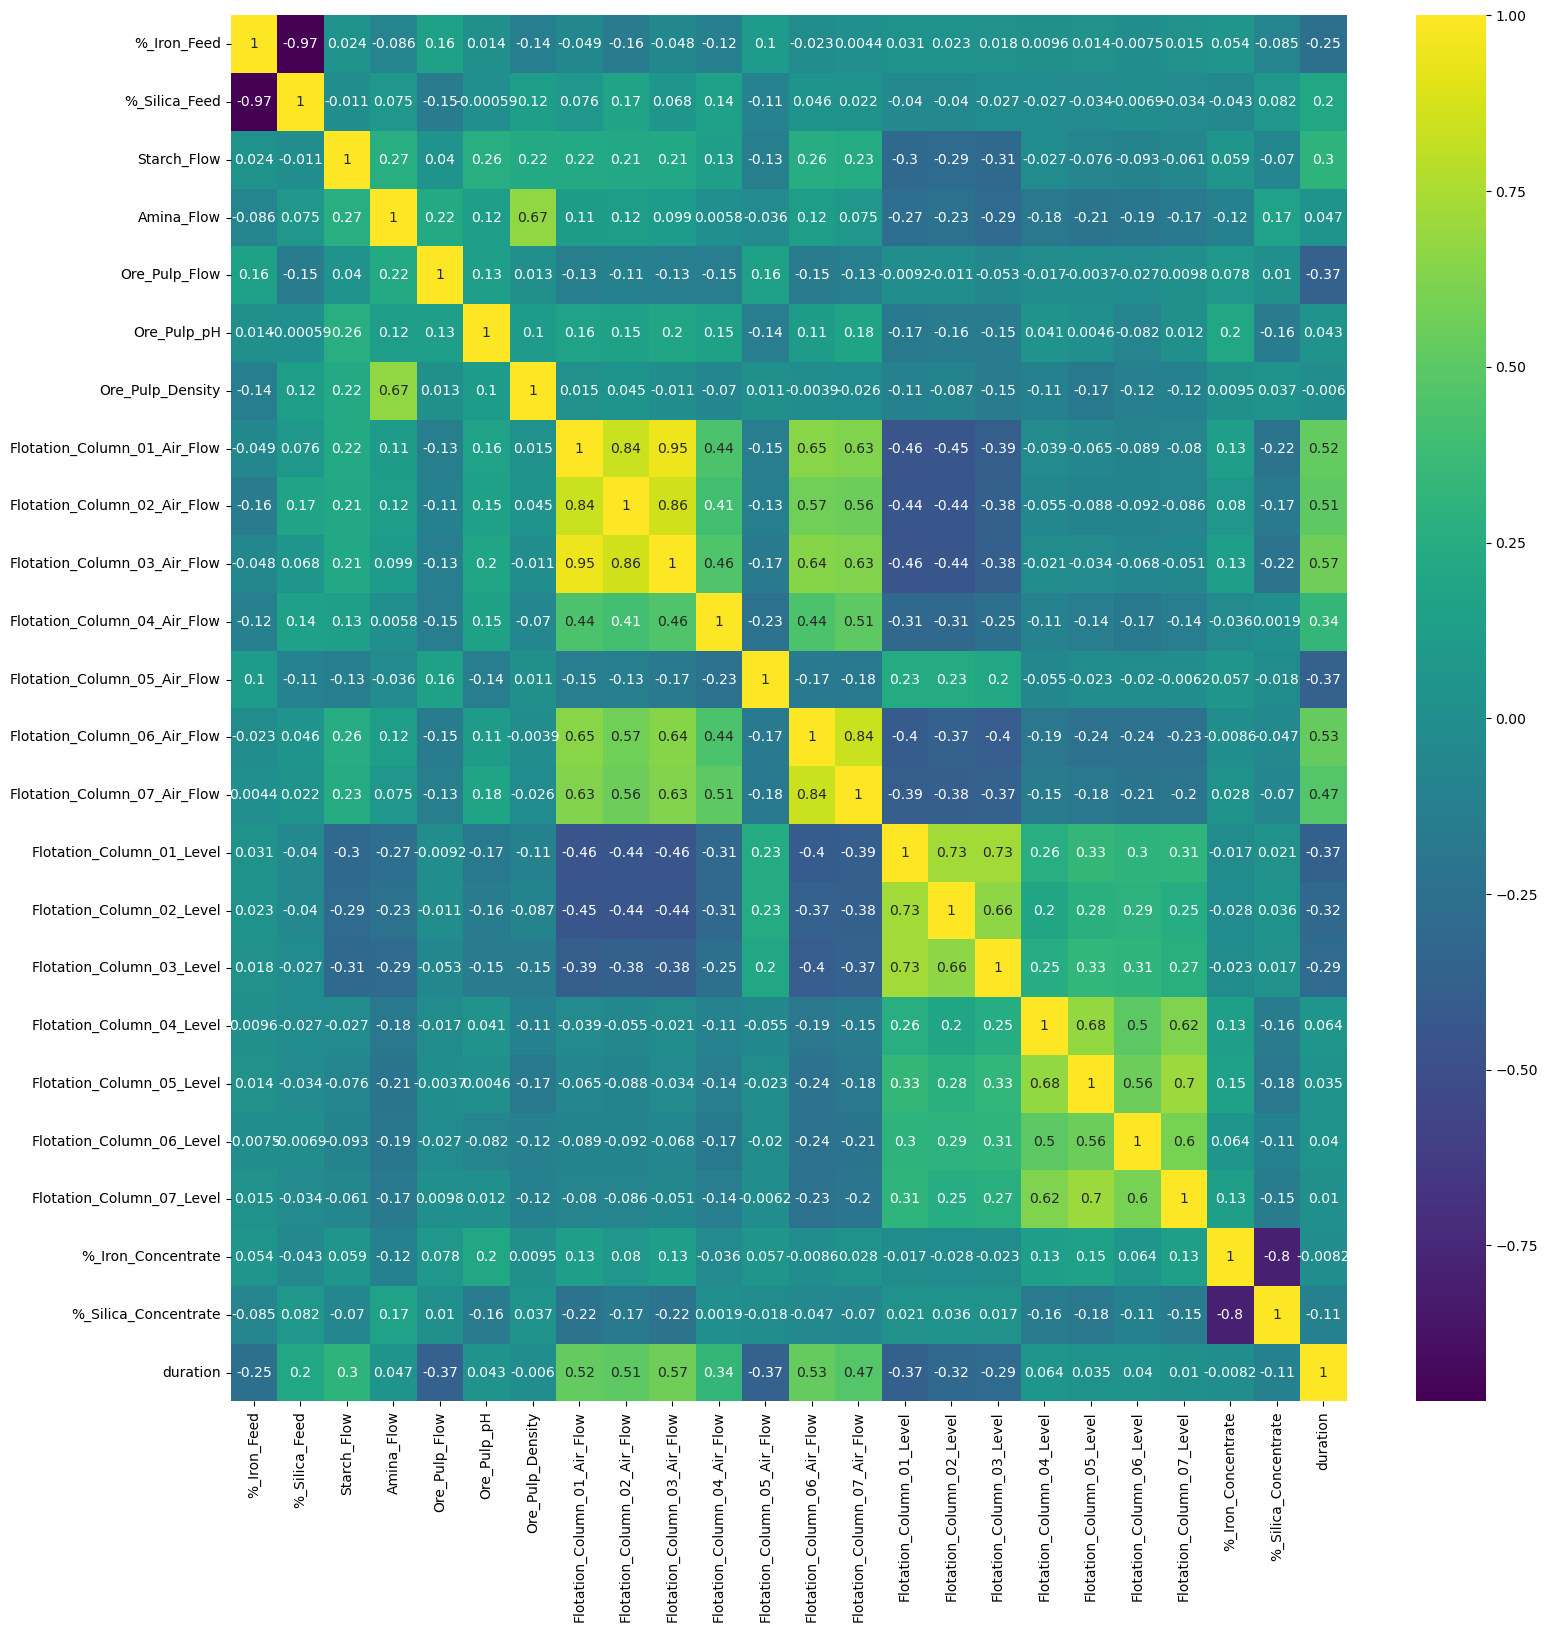

In [22]:
fig = plt.figure(figsize=(18,18))

sns.heatmap(dt_df.corr(), annot=True, cmap='viridis')

* First you can tell the **% of silica** is negatively corelated to the **% of iron concentrate**, which makes sense since they are separately desired and undesired substance of the process, purity and impurity
* Secondly, the **airflow in column 1** is in general positively corelated to the **airflow in column 2-7** except for column 5, which arise a potential doubt deserve diving deeper. Also we can tell the larger the airflow is, the lower the flotation level is in the responding column.
* Thirdly, we can see from the correlation heat map that the **ore pulp flow** and **starch flow** barely have influence on the final product -- % iron and % silica. on top of the fact that they both have positive corelation with the airflow measured in the columns, we can later verify the underlying collinearity by eigenvalue.

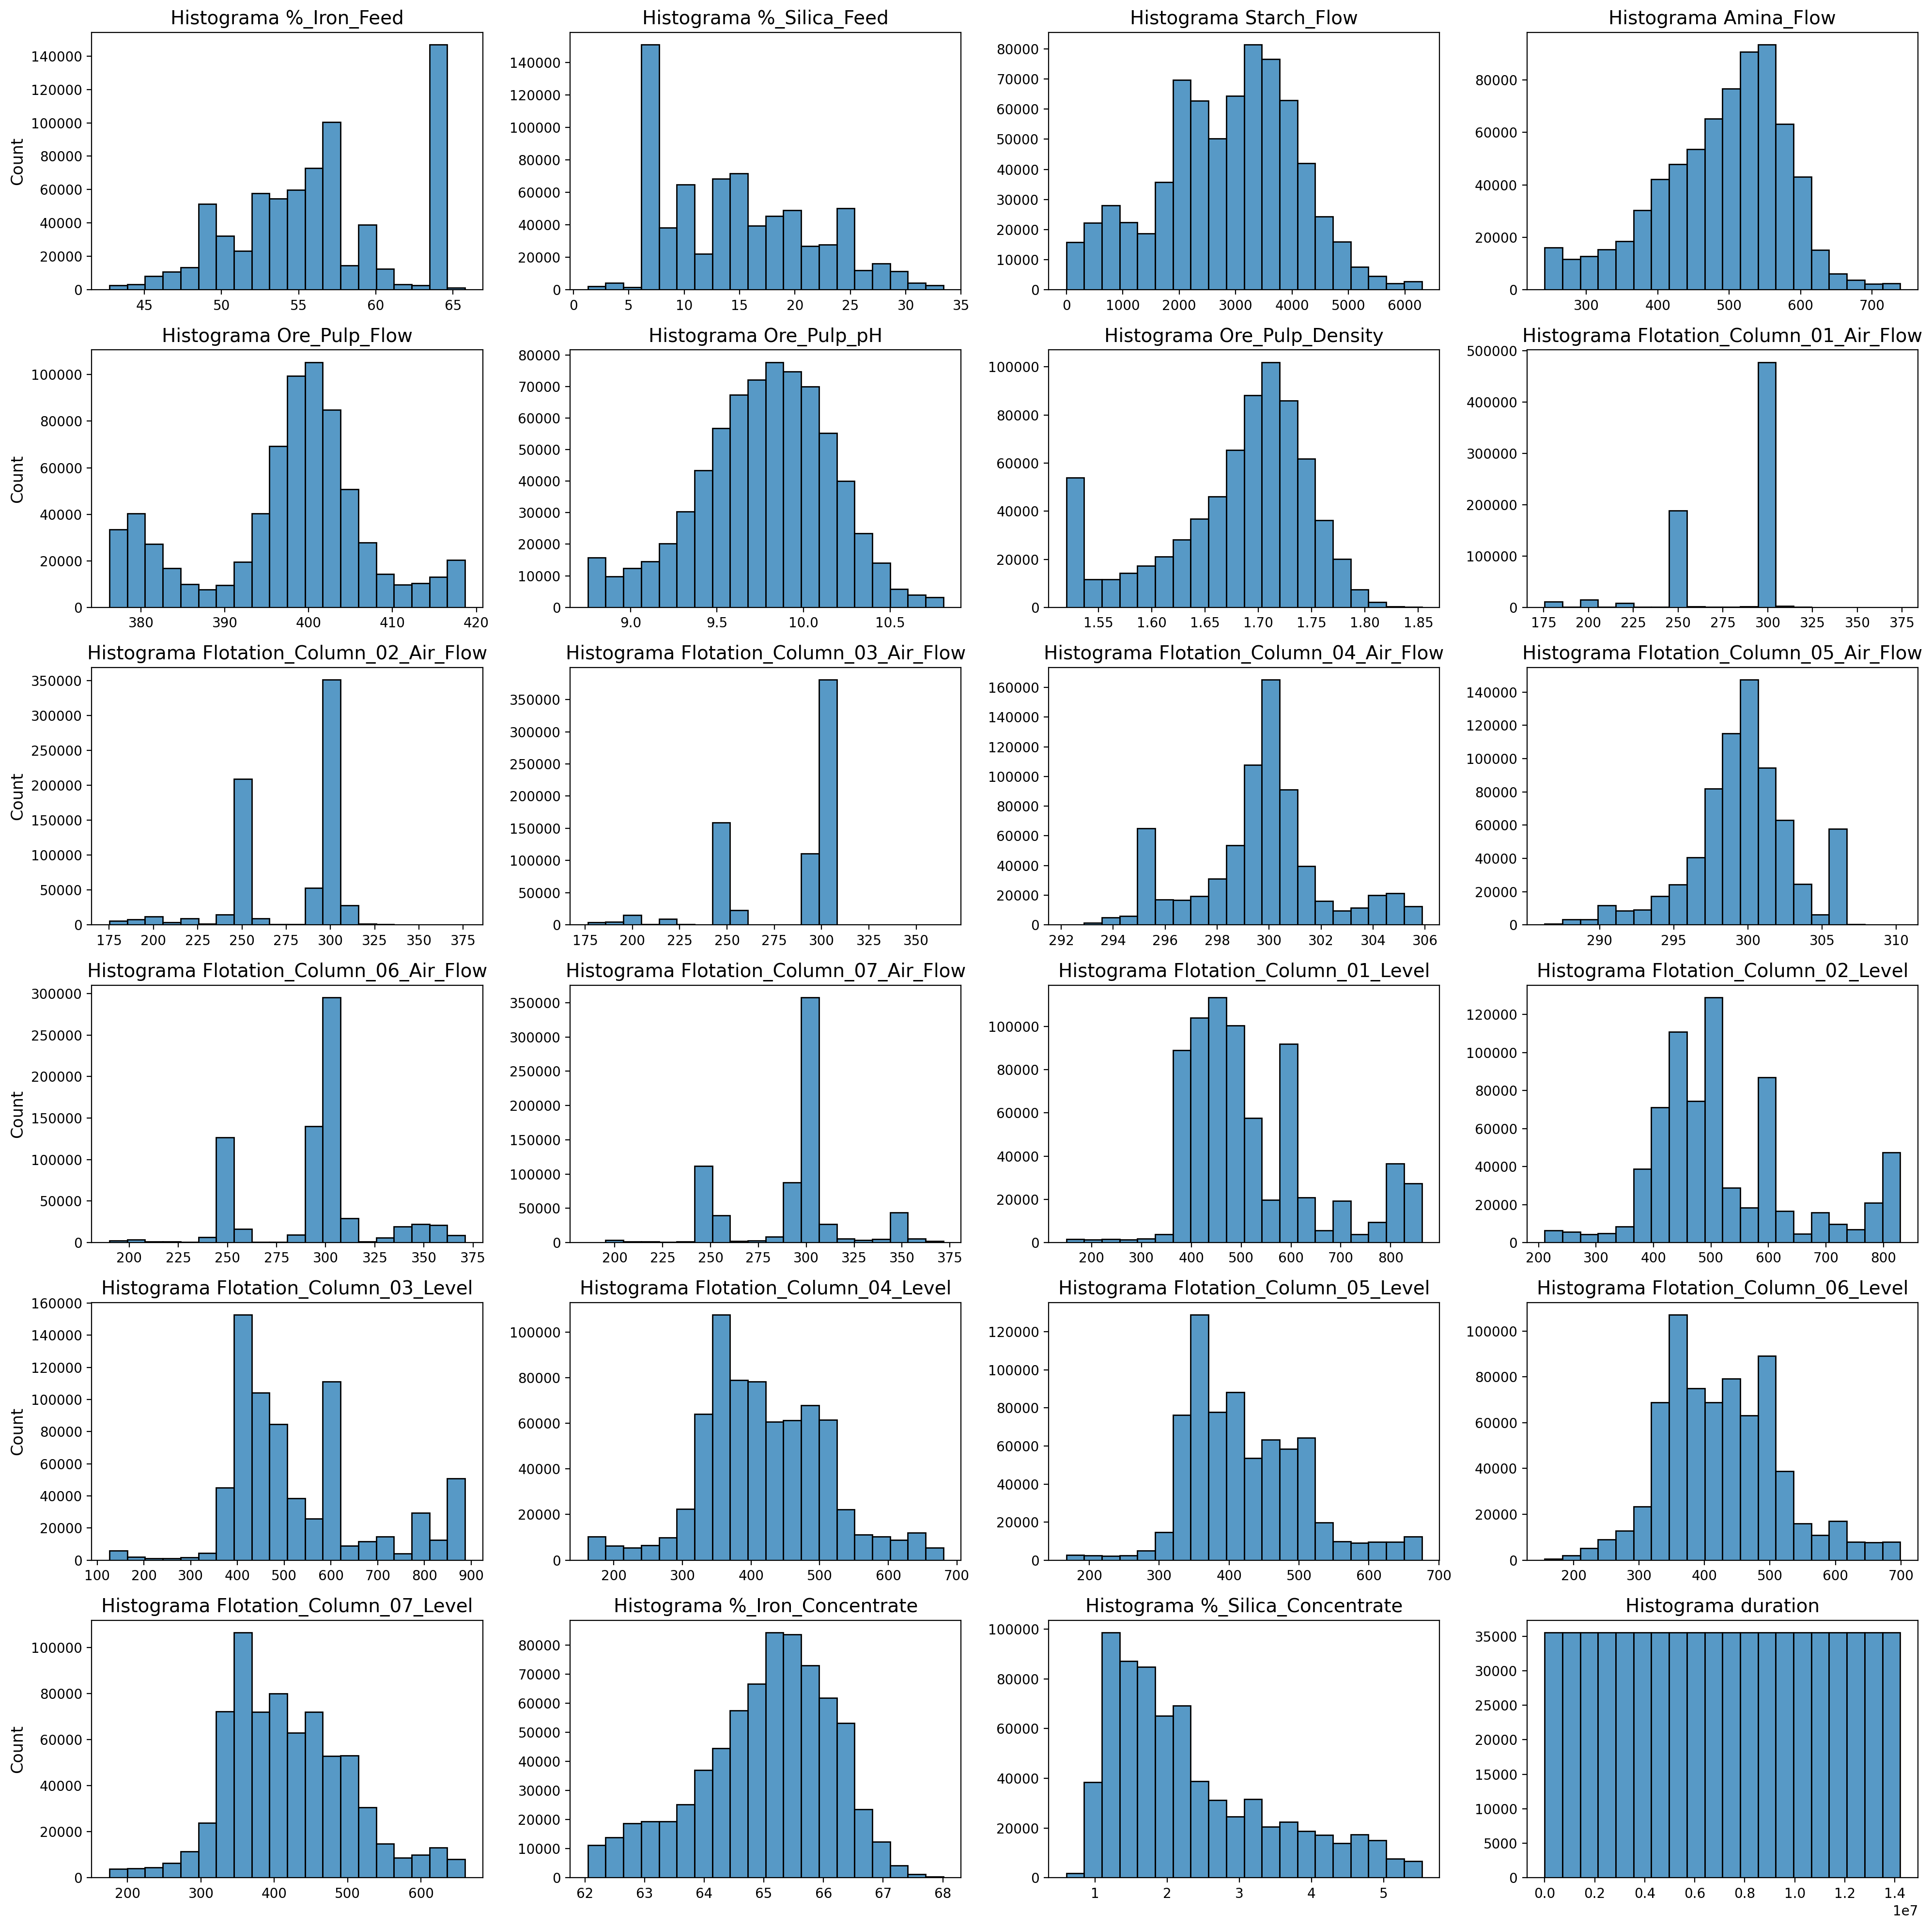

In [23]:
plt.figure(figsize=(20,20),dpi=200)
for i , n in enumerate(dt_df.columns.to_list()):
    plt.subplot(6,4,i+1)
    ax = sns.histplot(data=dt_df, x=n, kde=False, bins=20)#, multiple="stack")
    plt.title(f"Histograma {n}", fontdict={"fontsize":14})
    plt.xlabel("")
    plt.ylabel(ax.get_ylabel(), fontdict={"fontsize":12})
    if i not in [0,4,8,12,16,20,24]:
        plt.ylabel("")
    

plt.tight_layout();

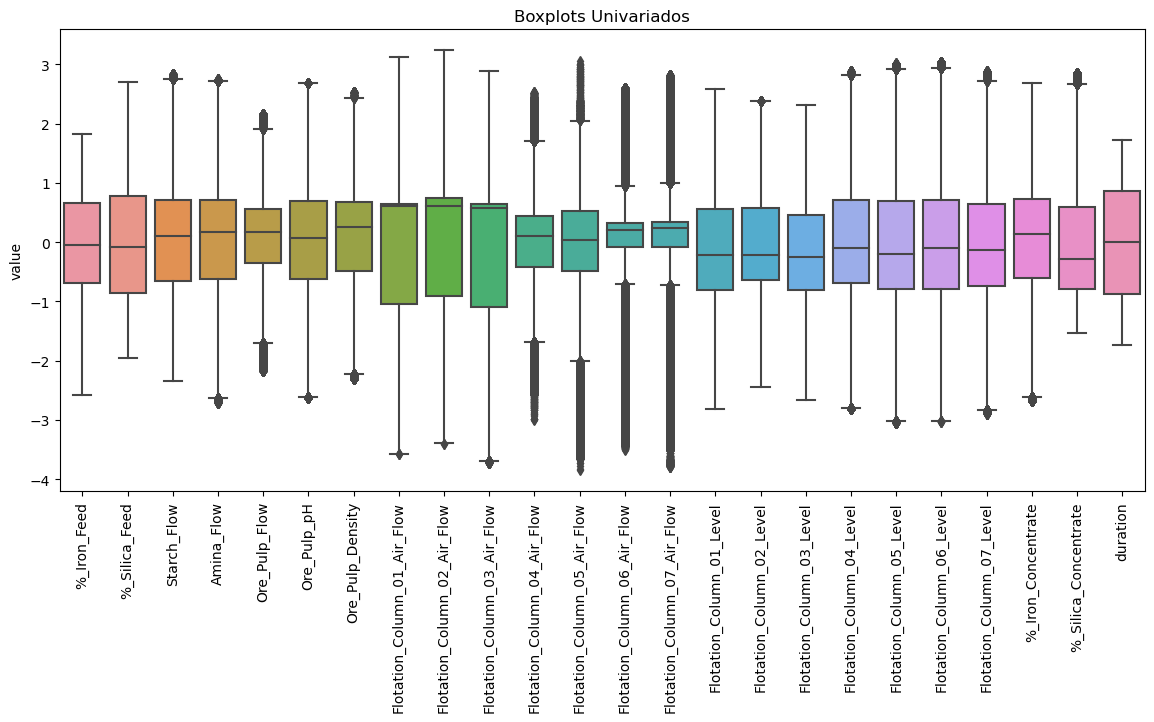

In [24]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

z = pd.DataFrame(scaler.fit_transform(dt_df), columns=dt_df.columns, index=dt_df.index)
z = z.melt()

plt.figure(figsize=(14,6),dpi=100)
sns.boxplot(x=z["variable"], y=z["value"]);
plt.xticks(rotation=90);
plt.xlabel("");
plt.title("Boxplots Univariados");

### TimeSeries Trend

In [29]:
df_h = dt_df.resample('H').first()
df_h.index.names = ['Date']

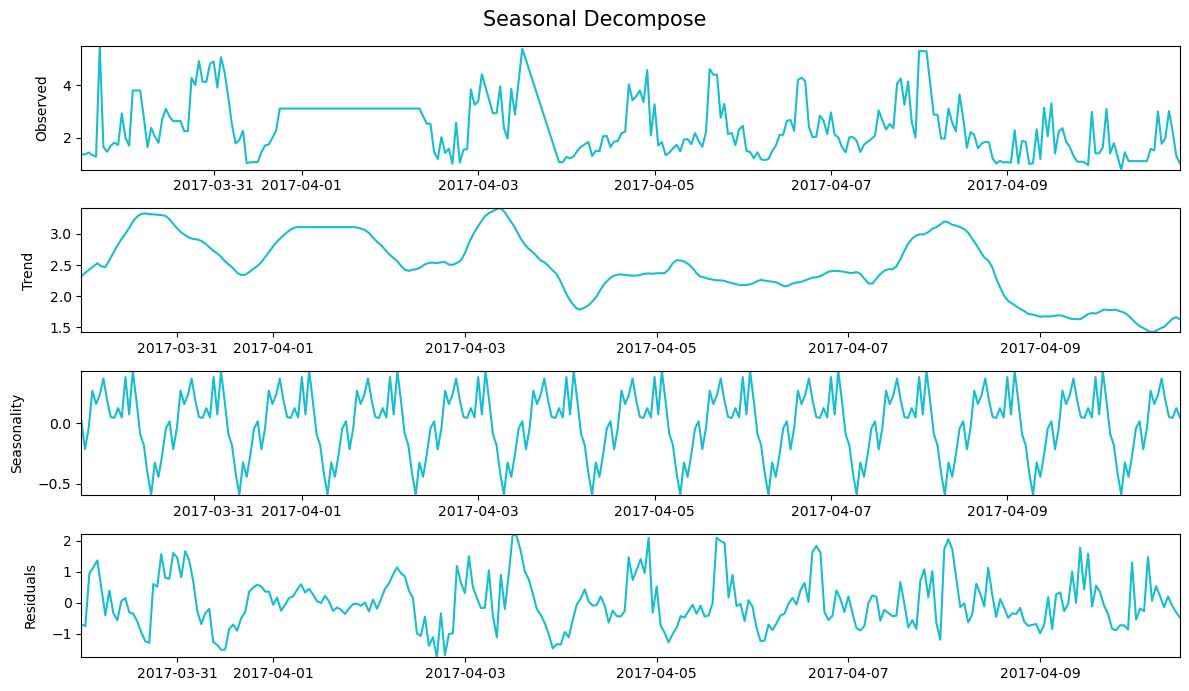

In [37]:
result = seasonal_decompose(df_h["%_Silica_Concentrate"][:300])

def decompose_plot(result):

    fig,axes = plt.subplots(ncols=1,nrows=4,figsize=(12,7))

    axes[0].plot(result.observed.index, result.observed.values, color='tab:cyan')
    axes[0].set_ylabel("Observed",fontdict={"size":10,},labelpad=10)
    axes[0].set_xticks(axes[0].get_xticks(), rotation=45)

    axes[1].plot(result.trend.index, result.trend.values, color='tab:cyan')
    axes[1].set_ylabel("Trend",fontdict={"size":10,},labelpad=10)

    axes[2].plot(result.seasonal.index, result.seasonal.values, color='tab:cyan')
    axes[2].set_ylabel("Seasonality",fontdict={"size":10,},labelpad=10)

    axes[3].plot(result.resid.index, result.resid.values, color='tab:cyan')
    axes[3].set_ylabel("Residuals",fontdict={"size":10,},labelpad=10)
    
    for n in range(0,4):
        axes[n].autoscale(axis="both",tight=True)

    fig.suptitle("Seasonal Decompose",fontsize=15)
    plt.tight_layout()

decompose_plot(result)

### Supervised TimeDiff Learning

In [39]:
dt_df.columns

Index(['%_Iron_Feed', '%_Silica_Feed', 'Starch_Flow', 'Amina_Flow',
       'Ore_Pulp_Flow', 'Ore_Pulp_pH', 'Ore_Pulp_Density',
       'Flotation_Column_01_Air_Flow', 'Flotation_Column_02_Air_Flow',
       'Flotation_Column_03_Air_Flow', 'Flotation_Column_04_Air_Flow',
       'Flotation_Column_05_Air_Flow', 'Flotation_Column_06_Air_Flow',
       'Flotation_Column_07_Air_Flow', 'Flotation_Column_01_Level',
       'Flotation_Column_02_Level', 'Flotation_Column_03_Level',
       'Flotation_Column_04_Level', 'Flotation_Column_05_Level',
       'Flotation_Column_06_Level', 'Flotation_Column_07_Level',
       '%_Iron_Concentrate', '%_Silica_Concentrate', 'duration'],
      dtype='object')

In [41]:
list_cols = [col for col in dt_df.columns.to_list()]  # Use this if I want to include all explanatory variables.

# list_cols = [col for col in df.columns.to_list() if "Flotation" not in col]  # Use this to exclude flotation air/level variables.
# flotation_cols = [col for col in df.columns.to_list() if "Flotation" in col] # Use this to exclude flotation air/level variables.

list_cols.remove("%_Silica_Concentrate")
list_cols.remove("%_Iron_Concentrate")

# Resample the original df every 15 minutes.
df_15 = dt_df.resample("15min").first()
df_15 = df_15.drop("%_Iron_Concentrate", axis=1)

# df_15 = df_15.drop(flotation_cols, axis=1)  # Use this only if I do not want to include flotation air/level variables.

window_size = 3

# Taking advantage of the time factor, I add lagged explanatory variables at 15min, 30min, and 45min, respectively
# (these are the ones that were updated every 20s)

for col_name in list_cols:
    for i in range(window_size):
        df_15[f"{col_name} ({-15*(i+1)}mins)"] = df_15[f"{col_name}"].shift(periods=i+1)

# Resample from 15min to 1hour
df_h = df_15.resample('H').first()

# Here I change the name of my index.
df_h.index.names = ['Date']

In [44]:
# Add lagged values of the target variable as explanatory variables, lagged by 1, 2, and 3 hours respectively.
col_name = "%_Silica_Concentrate"
window_size = 3

for i in range(window_size):
    df_h[f"{col_name} ({-i-1}h)"] = df_h[f"{col_name}"].shift(periods=i+1)

# Make the target variable the first column.
x = df_h.columns.to_list()
x.remove("%_Silica_Concentrate")
x.insert(0, "%_Silica_Concentrate")
df_h = df_h[x]

df_h = df_h.dropna()  # Remove rows with missing values due to the shift().
df_h = df_h.astype("float32")  # Convert data to float32 for faster computation.
print(df_h.shape)

(3946, 92)


I create performance reporting functions for my model, a tracker to keep track of metrics, and also add a function to perform a time series split (where temporal order is respected).

In [78]:
def plot_time_series(timesteps, values, start=0, end=None, label=None):#, #color="blue"):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
  # Plot the series
    sns.lineplot(x=timesteps[start:end], y=values[start:end], label=label)
    plt.xlabel("Date")
    plt.ylabel("% Silica Concentrate")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
def timeseries_models_tracker_df():
    reg_models_scores_df = pd.DataFrame(
        columns=["model_name", "MAE", "RMSE", "MASE", "R2", "MAPE"])

    return reg_models_scores_df

def timeseries_report_model(y_test, model_preds, tracker_df="none", model_name="model_unknown", seasonality=1, naive=False):
    mae = round(mean_absolute_error(y_test, model_preds), 4)
    rmse = round(mean_squared_error(y_test, model_preds) ** 0.5, 4)
    mase = round(mean_absolute_scaled_error(y_test, model_preds, seasonality, naive),4)
    r2 = round(r2_score(y_test, model_preds), 4)
    mape = round(mean_absolute_percentage_error(y_test, model_preds), 4)

    print("MAE: ", mae)
    print("RMSE :", rmse)
    print("MASE :", mase)
    print("R2 :", r2)
    print("MAPE :", mape)

    if isinstance(tracker_df, pd.core.frame.DataFrame):
        tracker_df.loc[tracker_df.shape[0]] = [
            model_name, mae, rmse, mase, r2, mape]
    else:
        pass
    
def mean_absolute_scaled_error(y_true, y_pred, seasonality=1, naive=False):
    """
    Implement MASE (assuming no seasonality of data).
    """
    y_true = np.array(y_true)
    #y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true-y_pred))

    # Find MAE of naive forecast (no seasonality)
    if naive:
        mae_naive_no_season = np.mean(np.abs(y_true - y_pred))
        
    else :
        mae_naive_no_season = np.mean(np.abs(y_true[seasonality:] - y_true[:-seasonality])) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season


# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

### LSTM

In [48]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [45]:
df_forecast = df_h.copy()
df_forecast.shape

(3946, 92)

In [72]:
tracker = timeseries_models_tracker_df()

In [47]:
X = df_forecast.drop("%_Silica_Concentrate", axis=1)
y = df_forecast["%_Silica_Concentrate"]

In [49]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(X,y,test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3551, 395, 3551, 395)

In [65]:
warnings.filterwarnings("ignore")
def objective(trial, X,y):


    
    param_grid = {
        "random_state": 123,
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt']),#,"goss"]),
        "device_type": trial.suggest_categorical("device_type", ['cpu']),
        "n_estimators": trial.suggest_int("n_estimators", 25, 10000,step=100), #for large datasets this should be very high
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 190), # Also change this for large datasets, should be small to avoid overfitting
        "max_depth": trial.suggest_int("max_depth", 2, 80),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 800, step=20), #modify this for large datasets, causes overfittin if too low
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0001, 1000, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0001, 1000, log=True),
        #"min_split_gain": trial.suggest_float("min_split_gain", 0, 3),
        "subsample": trial.suggest_float("subsample", 0.05, 1, step=0.05),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [0,1]), #[0,1] bagging
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1, step=0.1),
    }
    
    #min_data_in_leaf # min_child_samples
    
    # Aqui defino funcion a minimizar, usare el RMSE (Root Mean Squared Error)
    def rmse(y_val,y_pred):
        is_higher_better = False
        name = "rmse"
        value = mean_squared_error(y_val,y_pred, squared=False)
        return name, value, is_higher_better
    
    cv_scores = np.empty(5)
    
    tscv = TimeSeriesSplit(n_splits=5, max_train_size=None)
    
    for idx , (train_index, val_index) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        #print(y_train.shape, y_val.shape)

        model = LGBMRegressor(objective="regression", silent=True,**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=rmse,
            early_stopping_rounds=100,
            categorical_feature="auto",   # cat_idx, #specifiy categorial features.
            callbacks=[LightGBMPruningCallback(trial, "l2", report_interval=20)],  # Add a pruning callback
            verbose=0)

        preds =  model.predict(X_val)
        rmse = mean_squared_error(y_val,preds, squared=False)

        cv_scores[idx] = rmse

    
    return np.mean(cv_scores)

In [66]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor",sampler=TPESampler(),
                            pruner=optuna.pruners.PercentilePruner(50, n_startup_trials=5, n_warmup_steps=50))

#study.enqueue_trial(try_this_first)
func = lambda trial: objective(trial, train_windows, train_labels)
study.optimize(func, n_trials=100)

[I 2023-04-14 20:06:45,615] A new study created in memory with name: LGBM Regressor
[I 2023-04-14 20:06:46,696] Trial 0 finished with value: 0.8109004958352836 and parameters: {'boosting_type': 'gbdt', 'device_type': 'cpu', 'n_estimators': 8325, 'learning_rate': 0.2136801933659405, 'num_leaves': 122, 'max_depth': 24, 'min_child_samples': 290, 'reg_alpha': 0.4089594656291566, 'reg_lambda': 233.41962530839834, 'subsample': 0.55, 'subsample_freq': 1, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.8109004958352836.
[I 2023-04-14 20:06:47,790] Trial 1 finished with value: 0.8149075483133782 and parameters: {'boosting_type': 'gbdt', 'device_type': 'cpu', 'n_estimators': 2625, 'learning_rate': 0.20374443271553472, 'num_leaves': 24, 'max_depth': 65, 'min_child_samples': 550, 'reg_alpha': 0.00011716269934726968, 'reg_lambda': 0.005714841791728027, 'subsample': 0.45, 'subsample_freq': 0, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.8109004958352836.
[I 2023-04-14 20:06:48,981

In [68]:
#mejores hyperparametros, sin variables explicativas mas alla de variable objetivo retrasada.
params = study.best_params
model = LGBMRegressor(objective="regression",random_state=123,**params)
model.fit(train_windows, train_labels)

LGBMRegressor(colsample_bytree=0.8, device_type='cpu',
              learning_rate=0.2514458173401127, max_depth=48,
              min_child_samples=90, n_estimators=2125, num_leaves=128,
              objective='regression', random_state=123,
              reg_alpha=0.0042343839479169615, reg_lambda=8.01369798587411,
              subsample=0.6500000000000001, subsample_freq=1)

In [75]:
preds = model.predict(test_windows)
timeseries_report_model(test_labels, preds, tracker, model_name="Experimento 4, LightGBM",
                        seasonality=1, naive=False)

MAE:  0.6045
RMSE : 0.8177
MASE : 1.1928
R2 : 0.5233
MAPE : 0.2752


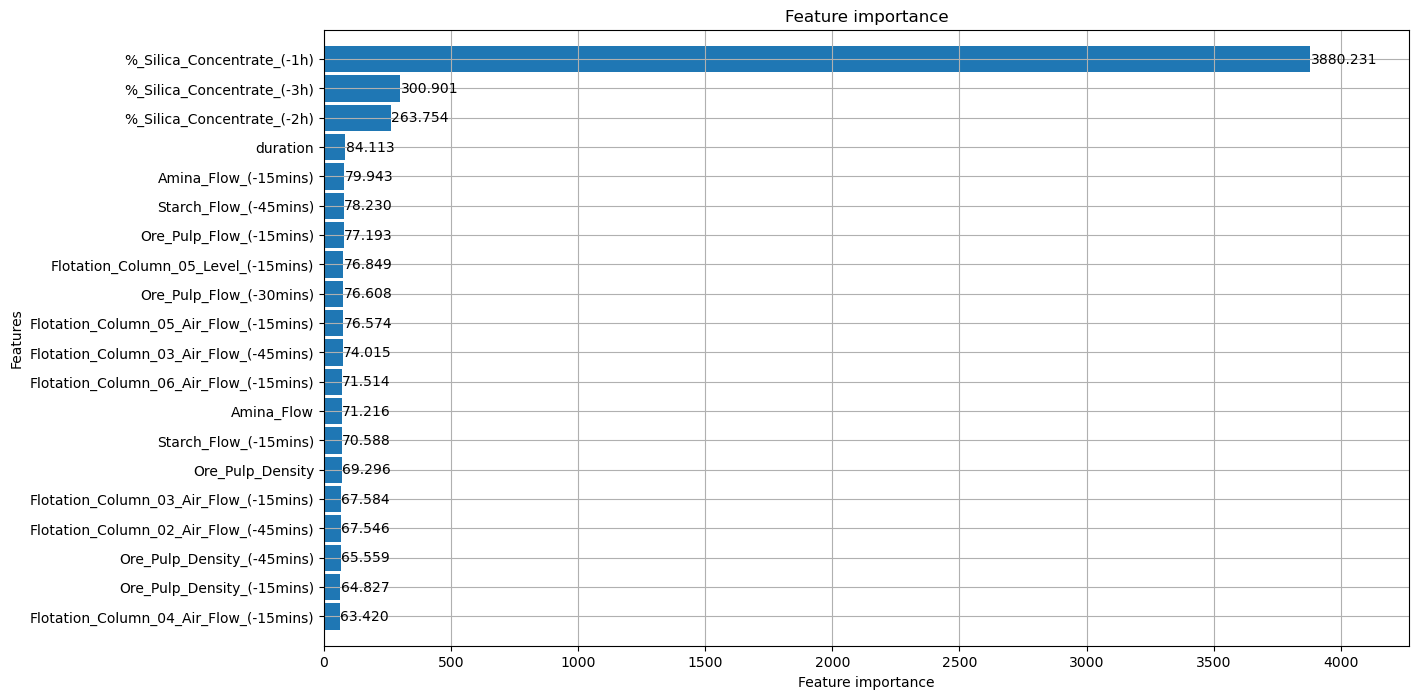

In [76]:
plot_importance(model, max_num_features = 20, height=.9, importance_type="gain", figsize=(14,8));

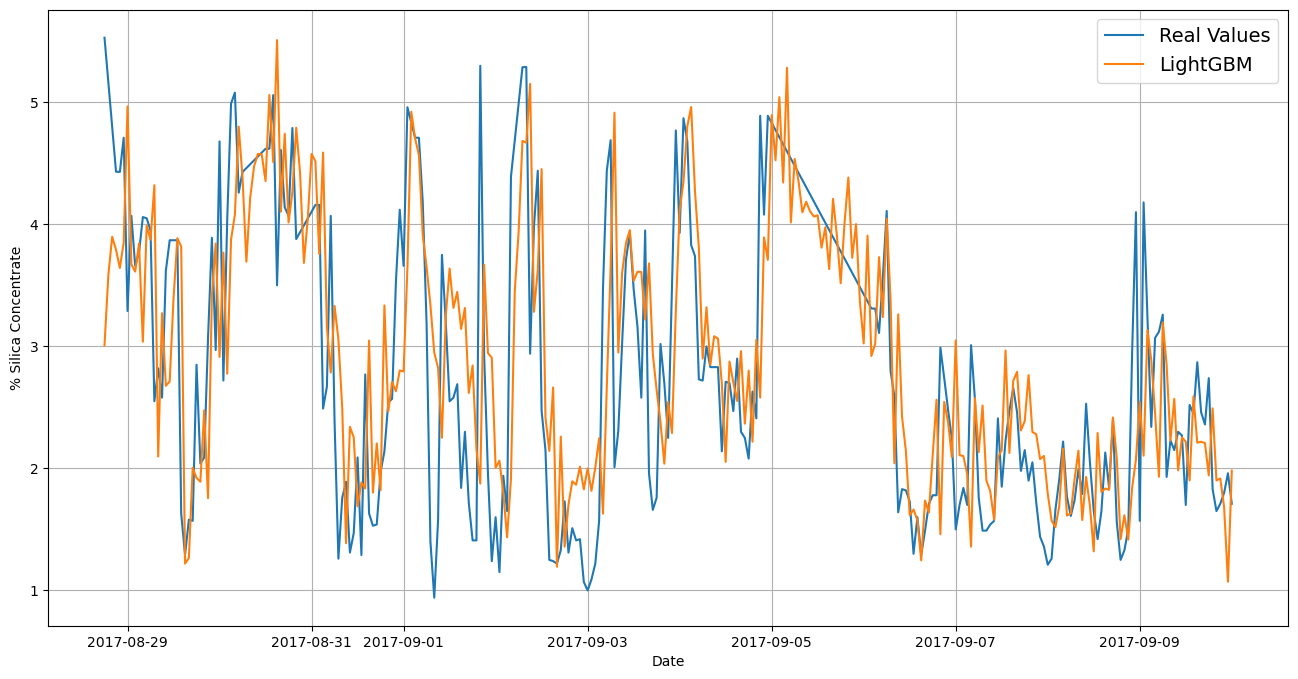

In [80]:
plt.figure(figsize=(16,8),dpi=100)
plot_time_series(test_labels.index, test_labels, label="Real Values", start=100)
plot_time_series(test_labels.index, preds,label="LightGBM", start=100)

### VIF approach

In [ ]:
vif_data = df.drop(columns=['date', '%_Silica_Concentrate'])
vif_data.head()

In [ ]:
vif_df = pd.DataFrame(index=vif_data.columns, columns=['VIF'], data=np.ones((22,1))*1000)
max(vif_df.VIF)

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

print(bcolors.BOLD + "Warning: No active frommets remain. Continue?" + bcolors.ENDC)

In [ ]:

# Prepare data for VIF
vif_data = df.drop(columns=['date', "%_Iron_Concentrate", '%_Silica_Concentrate'])
vif_data = vif_data.astype(float)

# Create a new DataFrame to hold the VIF results
vif_df = pd.DataFrame(index=vif_data.columns, columns=['VIF_0'], data=np.ones((21,1))*1000)
vif_record_df = vif_df

# Counter
k=0

while True:
    # Loop through each column in the DataFrame
    for i, col in enumerate(vif_df.index.to_list()):

        # Calculate the VIF for the current column
        vif = variance_inflation_factor(np.array(vif_data.values), i)
    
        # Add the VIF value to the DataFrame
        vif_df.loc[col, 'VIF_{}'.format(k)] = vif
    
    # Record the VIF column for each iteration
    vif_record_df = pd.concat([vif_record_df, vif_df], axis=1)
    
    
    # Sort the VIF and remove the > 10
    sorted_vif_df = vif_df.sort_values(by='VIF_{}'.format(k), ascending=False)
    print(sorted_vif_df)
    
    if sorted_vif_df['VIF_{}'.format(k)][0] > 10:
        
        # Print out the removed column
        print(bcolors.BOLD + "Removing {} iteration... {}".format(k, sorted_vif_df.index[0]) + bcolors.ENDC)
        
        vif_df = vif_df.drop(index=sorted_vif_df.index[0], axis=0)
        vif_data = vif_data.drop(columns=sorted_vif_df.index[0])
        k+=1
    
    else:
        break


In [ ]:
vif_record_df

In [ ]:
p = sns.barplot(data=vif_record_df, x=vif_record_df.index, y="VIF_0")
p.set_xticklabels(
    labels=vif_df.index.tolist(), rotation=30)